<a href="https://colab.research.google.com/github/LimJongYoon/2020MLP/blob/master/09_ML_lesson4_collab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from fastai.collab import *
from fastai.tabular import *

In [17]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Collaborative filtering example

`collab` models use data in a `DataFrame` of user, items, and ratings.

In [0]:
user,item,title = 'userId','movieId','title'

In [19]:
path = untar_data(URLs.ML_SAMPLE)
path

PosixPath('/root/.fastai/data/movie_lens_sample')

In [20]:
path.ls()

[PosixPath('/root/.fastai/data/movie_lens_sample/ratings.csv')]

In [21]:
ratings = pd.read_csv(path/'ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,73,1097,4.0,1255504951
1,561,924,3.5,1172695223
2,157,260,3.5,1291598691
3,358,1210,5.0,957481884
4,130,316,2.0,1138999234


That's all we need to create and train a model:

In [0]:
data = CollabDataBunch.from_df(ratings, seed=42)

In [0]:
y_range = [0,5.5]

In [0]:
learn = collab_learner(data, n_factors=50, y_range=y_range)

In [25]:
learn.fit_one_cycle(3, 5e-3)

epoch,train_loss,valid_loss,time
0,1.632532,0.941641,00:01
1,0.848372,0.676851,00:01
2,0.647856,0.664647,00:01


## Movielens 100k

Let's try with the full Movielens 100k data dataset, available from http://files.grouplens.org/datasets/movielens/ml-100k.zip

In [0]:
folder = 'ml-100k' # 패스 오류가 나서 수정

In [0]:
#path=Config.data_path()/'ml-100k' # 저번에도 이렇게하면 root 아래 .fastai 폴더 생성해서 하는데 꼭 오류가난다.
path = Path('data')
dest = path/folder
dest.mkdir(parents=True, exist_ok=True)

In [44]:
path.ls()

[PosixPath('data/ml-100k/mku.sh'),
 PosixPath('data/ml-100k/u1.base'),
 PosixPath('data/ml-100k/u.info'),
 PosixPath('data/ml-100k/README'),
 PosixPath('data/ml-100k/allbut.pl'),
 PosixPath('data/ml-100k/ua.test'),
 PosixPath('data/ml-100k/u1.test'),
 PosixPath('data/ml-100k/u2.test'),
 PosixPath('data/ml-100k/u3.base'),
 PosixPath('data/ml-100k/u.item'),
 PosixPath('data/ml-100k/u3.test'),
 PosixPath('data/ml-100k/data'),
 PosixPath('data/ml-100k/ua.base'),
 PosixPath('data/ml-100k/u.occupation'),
 PosixPath('data/ml-100k/u.user'),
 PosixPath('data/ml-100k/u5.base'),
 PosixPath('data/ml-100k/u.genre'),
 PosixPath('data/ml-100k/ub.test'),
 PosixPath('data/ml-100k/ub.base'),
 PosixPath('data/ml-100k/u.data'),
 PosixPath('data/ml-100k/u4.test'),
 PosixPath('data/ml-100k/u2.base'),
 PosixPath('data/ml-100k/u5.test'),
 PosixPath('data/ml-100k/u4.base')]

In [45]:
ratings = pd.read_csv(path/'u.data', delimiter='\t', header=None,
                      names=[user,item,'rating','timestamp'])

ratings.head()

,userId,movieId,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [46]:
movies = pd.read_csv(path/'u.item',  delimiter='|', encoding='latin-1', header=None,
                    names=[item, 'title', 'date', 'N', 'url', *[f'g{i}' for i in range(19)]])
movies.head()

,movieId,title,date,N,url,g0,g1,g2,g3,g4,g5,g6,g7,g8,g9,g10,g11,g12,g13,g14,g15,g16,g17,g18
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0


In [47]:
len(ratings)

100000

In [48]:
rating_movie = ratings.merge(movies[[item, title]])
rating_movie.head()

,userId,movieId,rating,timestamp,title
0,196,242,3,881250949,Kolya (1996)
1,63,242,3,875747190,Kolya (1996)
2,226,242,5,883888671,Kolya (1996)
3,154,242,3,879138235,Kolya (1996)
4,306,242,5,876503793,Kolya (1996)


In [0]:
data = CollabDataBunch.from_df(rating_movie, seed=42, valid_pct=0.1, item_name=title)

In [50]:
data.show_batch()

userId,title,target
487,Casper (1995),3.0
889,"Right Stuff, The (1983)",4.0
293,Jackie Chan's First Strike (1996),2.0
22,Star Trek VI: The Undiscovered Country (1991),4.0
479,To Catch a Thief (1955),4.0


In [0]:
y_range = [0,5.5]

In [0]:
learn = collab_learner(data, n_factors=40, y_range=y_range, wd=1e-1)

epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


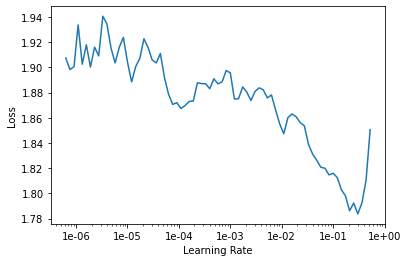

In [53]:
learn.lr_find()
learn.recorder.plot(skip_end=15)

In [54]:
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,0.965074,0.943363,00:14
1,0.874504,0.889737,00:14
2,0.773616,0.830849,00:14
3,0.663914,0.810933,00:15
4,0.559972,0.809765,00:15


In [0]:
learn.save('dotprod')

Here's [some benchmarks](https://www.librec.net/release/v1.3/example.html) on the same dataset for the popular Librec system for collaborative filtering. They show best results based on RMSE of 0.91, which corresponds to an MSE of `0.91**2 = 0.83`.

## Interpretation

### Setup

In [0]:
learn.load('dotprod');

In [57]:
learn.model

EmbeddingDotBias(
  (u_weight): Embedding(944, 40)
  (i_weight): Embedding(1654, 40)
  (u_bias): Embedding(944, 1)
  (i_bias): Embedding(1654, 1)
)

In [58]:
g = rating_movie.groupby(title)['rating'].count()
top_movies = g.sort_values(ascending=False).index.values[:1000]
top_movies[:10]

array(['Star Wars (1977)', 'Contact (1997)', 'Fargo (1996)', 'Return of the Jedi (1983)', 'Liar Liar (1997)',
       'English Patient, The (1996)', 'Scream (1996)', 'Toy Story (1995)', 'Air Force One (1997)',
       'Independence Day (ID4) (1996)'], dtype=object)

### Movie bias

In [59]:
movie_bias = learn.bias(top_movies, is_item=True)
movie_bias.shape

torch.Size([1000])

In [0]:
mean_ratings = rating_movie.groupby(title)['rating'].mean()
movie_ratings = [(b, i, mean_ratings.loc[i]) for i,b in zip(top_movies,movie_bias)]

In [0]:
item0 = lambda o:o[0]

In [62]:
sorted(movie_ratings, key=item0)[:15]

[(tensor(-0.3635),
  'Children of the Corn: The Gathering (1996)',
  1.3157894736842106),
 (tensor(-0.3349),
  'Lawnmower Man 2: Beyond Cyberspace (1996)',
  1.7142857142857142),
 (tensor(-0.2943), 'Cable Guy, The (1996)', 2.339622641509434),
 (tensor(-0.2828), 'Mortal Kombat: Annihilation (1997)', 1.9534883720930232),
 (tensor(-0.2702), 'Free Willy 3: The Rescue (1997)', 1.7407407407407407),
 (tensor(-0.2396), "Joe's Apartment (1996)", 2.2444444444444445),
 (tensor(-0.2358), 'Striptease (1996)', 2.2388059701492535),
 (tensor(-0.2348), 'Beautician and the Beast, The (1997)', 2.313953488372093),
 (tensor(-0.2311), 'Island of Dr. Moreau, The (1996)', 2.1578947368421053),
 (tensor(-0.2304), 'Crow: City of Angels, The (1996)', 1.9487179487179487),
 (tensor(-0.2275), 'Leave It to Beaver (1997)', 1.8409090909090908),
 (tensor(-0.2229), 'Bio-Dome (1996)', 1.903225806451613),
 (tensor(-0.2159), 'Showgirls (1995)', 1.9565217391304348),
 (tensor(-0.2141), 'Thinner (1996)', 2.4489795918367347),
 

In [63]:
sorted(movie_ratings, key=lambda o: o[0], reverse=True)[:15]

[(tensor(0.6238), "Schindler's List (1993)", 4.466442953020135),
 (tensor(0.5912), 'Titanic (1997)', 4.2457142857142856),
 (tensor(0.5836), 'Shawshank Redemption, The (1994)', 4.445229681978798),
 (tensor(0.5625), 'L.A. Confidential (1997)', 4.161616161616162),
 (tensor(0.5386), 'Silence of the Lambs, The (1991)', 4.28974358974359),
 (tensor(0.5221), 'Good Will Hunting (1997)', 4.262626262626263),
 (tensor(0.5219), 'Star Wars (1977)', 4.3584905660377355),
 (tensor(0.5098), 'Rear Window (1954)', 4.3875598086124405),
 (tensor(0.5069), 'Usual Suspects, The (1995)', 4.385767790262173),
 (tensor(0.5068), 'As Good As It Gets (1997)', 4.196428571428571),
 (tensor(0.4854), 'Close Shave, A (1995)', 4.491071428571429),
 (tensor(0.4838), 'Apt Pupil (1998)', 4.1),
 (tensor(0.4751), 'Godfather, The (1972)', 4.283292978208232),
 (tensor(0.4633), 'Vertigo (1958)', 4.251396648044692),
 (tensor(0.4624), 'Boot, Das (1981)', 4.203980099502488)]

### Movie weights

In [64]:
movie_w = learn.weight(top_movies, is_item=True)
movie_w.shape

torch.Size([1000, 40])

In [65]:
movie_pca = movie_w.pca(3)
movie_pca.shape

torch.Size([1000, 3])

In [0]:
fac0,fac1,fac2 = movie_pca.t()
movie_comp = [(f, i) for f,i in zip(fac0, top_movies)]

In [67]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(tensor(1.0897), 'Casablanca (1942)'),
 (tensor(1.0690), 'Wrong Trousers, The (1993)'),
 (tensor(1.0420),
  'Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1963)'),
 (tensor(1.0326), 'Close Shave, A (1995)'),
 (tensor(1.0276), 'Lawrence of Arabia (1962)'),
 (tensor(1.0265), 'Chinatown (1974)'),
 (tensor(0.9966), 'Third Man, The (1949)'),
 (tensor(0.9704), 'When We Were Kings (1996)'),
 (tensor(0.9603), 'Godfather, The (1972)'),
 (tensor(0.9461), 'Citizen Kane (1941)')]

In [68]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(tensor(-1.3342), 'Home Alone 3 (1997)'),
 (tensor(-1.2655), 'Jungle2Jungle (1997)'),
 (tensor(-1.2238), 'D3: The Mighty Ducks (1996)'),
 (tensor(-1.1983), "McHale's Navy (1997)"),
 (tensor(-1.1749), 'Congo (1995)'),
 (tensor(-1.1288), 'Bio-Dome (1996)'),
 (tensor(-1.0965), 'Free Willy 3: The Rescue (1997)'),
 (tensor(-1.0917), 'Mortal Kombat: Annihilation (1997)'),
 (tensor(-1.0858), 'Flipper (1996)'),
 (tensor(-1.0582), 'Leave It to Beaver (1997)')]

In [0]:
movie_comp = [(f, i) for f,i in zip(fac1, top_movies)]

In [70]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(tensor(1.1793), 'Braveheart (1995)'),
 (tensor(1.0779), 'Raiders of the Lost Ark (1981)'),
 (tensor(1.0521), 'Titanic (1997)'),
 (tensor(0.8886), "It's a Wonderful Life (1946)"),
 (tensor(0.8810), 'Independence Day (ID4) (1996)'),
 (tensor(0.8346), 'Pretty Woman (1990)'),
 (tensor(0.8320), 'American President, The (1995)'),
 (tensor(0.8228), 'Forrest Gump (1994)'),
 (tensor(0.8158), 'Back to the Future (1985)'),
 (tensor(0.8116), 'Return of the Jedi (1983)')]

In [71]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(tensor(-0.8661), 'Ready to Wear (Pret-A-Porter) (1994)'),
 (tensor(-0.8619), 'Sweet Hereafter, The (1997)'),
 (tensor(-0.8187), 'Trainspotting (1996)'),
 (tensor(-0.7937), 'Crumb (1994)'),
 (tensor(-0.7864), 'Cable Guy, The (1996)'),
 (tensor(-0.7838), 'Keys to Tulsa (1997)'),
 (tensor(-0.7721), 'Lost Highway (1997)'),
 (tensor(-0.7549), 'Jude (1996)'),
 (tensor(-0.7339), 'Spice World (1997)'),
 (tensor(-0.7327), 'Brazil (1985)')]

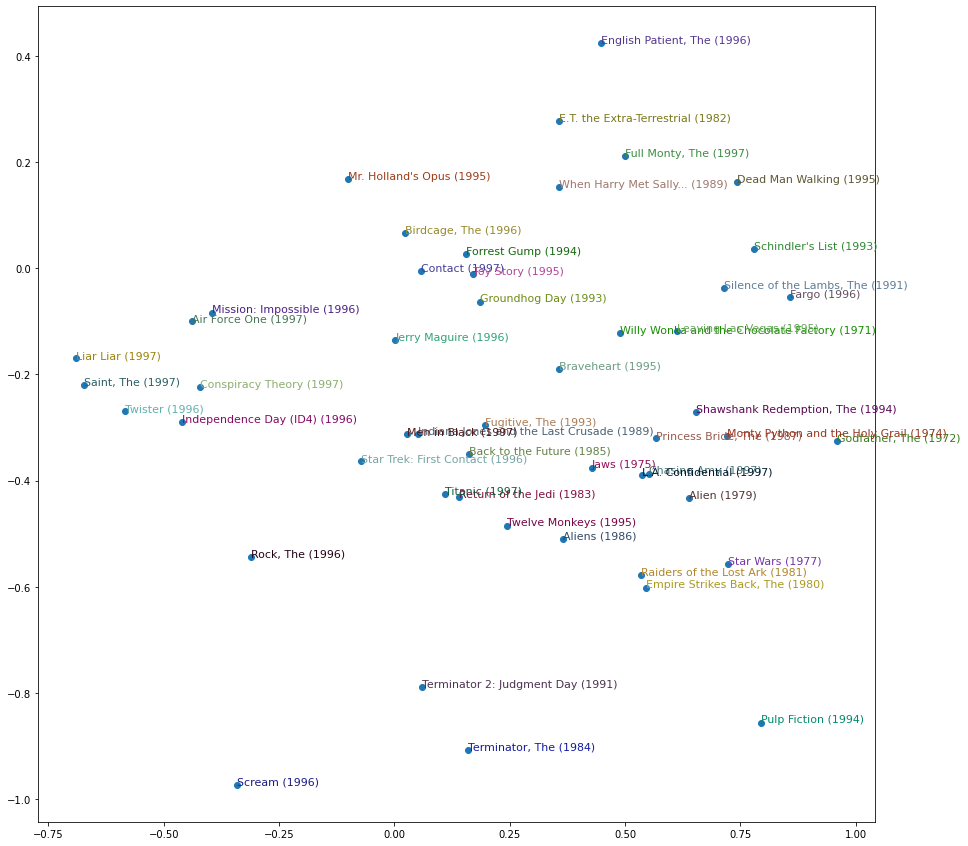

In [72]:
idxs = np.random.choice(len(top_movies), 50, replace=False)
idxs = list(range(50))
X = fac0[idxs]
Y = fac2[idxs]
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(top_movies[idxs], X, Y):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=11)
plt.show()